<img src="../docs/figure/icon.png" alt="Icon" width="1200">

## Asignment

The aim of project is to create a model that estimates the time taken for a delivery. Concretely, for a given delivery you must predict the total delivery duration seconds, i.e. the time taken from <br>
* Start: the time consumer submits the order (created at) to
* End: when the order will be delivered to the consumer(actual delivery time)

## Table of Contents
* [Data Description](#1)
* [Import Library](#2)
* [Data Preparation](#3)
* [Collinearity and Removing Redundancies](#4)
* [Multicollinearity and Feature Selection](#5)

## Data Description<a id='1'></a>

<b> Data Sources: </b>The dataset for this project is from  <a href="https://platform.stratascratch.com/data-projects/delivery-duration-prediction" target="_blank">StrataScratch</a> 

<b> Time Features </b><br>
* `created_at (object)`: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
* `actual_delivery_time (object)`: Timestamp in UTC when the order was delivered to the consumer

<b> Store Features </b><br>
* `store_id (int)`: an id representing the restaurant the order was submitted for
* `store_primary_category (object)`: cuisine category of the restaurant, e.g., italian, asian
* `order_protocol (float)`: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

<b> Order Features </b><br>
* `total_items (int)`: total number of items in the order
* `subtotal (int)`: total value of the order submitted (in cents)
* `num_distinct_items (int)`: number of distinct items included in the order
* `min_item_price (int)`: price of the item with the least cost in the order (in cents)
* `max_item_price (int)`: price of the item with the highest cost in the order (in cents)

<b> Market Features </b><br>
* `market_id (float)`: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
* `total_onshift_dashers (float)`: Number of available dashers who are within 10 miles of the store at the time of order creation
* `total_busy_dashers (float)`: Subset of above __total_onshift_dashers__ who are currently working on an order
* `total_outstanding_orders (float)`: Number of orders within 10 miles of this order that are currently being processed

<b> Predictions From Other Models </b><br>
* `estimated_order_place_duration (int)`: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
* `estimated_store_to_consumer_driving_duration (float)`: Estimated travel time between store and consumer (in seconds)

## Import Library <a id='2'></a>

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

project_path = os.path.abspath(os.path.join(".."))
sys.path.append(project_path)
from src.utils import create_dummies, correlation_heatmap, get_top_abs_correlations

## Data Preparation <a id='3'></a>

In [2]:
# load dataset
df = pd.read_csv('../data/raw/historical_data.csv')
df.head(2)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
# check duplicates
df.duplicated().any(axis=0)

np.False_

* Before calculating the total delivery duration time for each row, We need to convert the data type of the `created_at` and `actual_delivery_time` features.

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

* Now, let's create a few features that can help in model predicting as well as total delivery duration (target variable).

In [6]:
df['total_delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df['busy_dashers_ratio'] = df['total_busy_dashers'] / df['total_onshift_dashers']
df['estimated_non_prep_duration'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration']
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


* `total_onshift_dashers` feature has zero values, therefore inf data can be seen in `busy_dashers_ratio` feature. Let's convert these data types to nan and delete them in the next step.

In [7]:
df[df['busy_dashers_ratio'] == np.inf].head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
10426,3.0,2015-02-04 21:43:06,2015-02-04 22:50:30,6788,american,1.0,3,1130,2,398,309,0.0,6.0,10.0,446,238.0,4044.0,inf,684.0
18807,1.0,2015-02-04 17:31:56,2015-02-04 18:27:23,6381,cafe,4.0,2,720,2,275,345,0.0,1.0,2.0,251,352.0,3327.0,inf,603.0
19128,3.0,2015-01-29 19:12:19,2015-01-29 19:48:14,4592,other,4.0,3,1267,3,269,579,0.0,1.0,2.0,251,567.0,2155.0,inf,818.0
19131,3.0,2015-02-02 05:47:48,2015-02-02 06:11:59,4592,other,4.0,2,598,1,299,299,0.0,1.0,2.0,251,482.0,1451.0,inf,733.0
21851,3.0,2015-02-06 15:52:18,2015-02-06 16:32:48,2120,breakfast,4.0,1,249,1,129,129,0.0,1.0,0.0,251,522.0,2430.0,inf,773.0


In [8]:
df = df.replace([np.inf, -np.inf], np.nan)
df[df['busy_dashers_ratio'] == np.inf].head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration


<b>Handle Null Variables

In [9]:
display(df.isna().sum()), display(df.isna().sum() / len(df));

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
total_delivery_duration                             7
busy_dashers_ratio                              19877
estimated_non_prep_duration 

market_id                                       0.004999
created_at                                      0.000000
actual_delivery_time                            0.000035
store_id                                        0.000000
store_primary_category                          0.024110
order_protocol                                  0.005040
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           0.082369
total_busy_dashers                              0.082369
total_outstanding_orders                        0.082369
estimated_order_place_duration                  0.000000
estimated_store_to_consumer_driving_duration    0.002664
total_delivery_duration                         0.000035
busy_dashers_ratio             

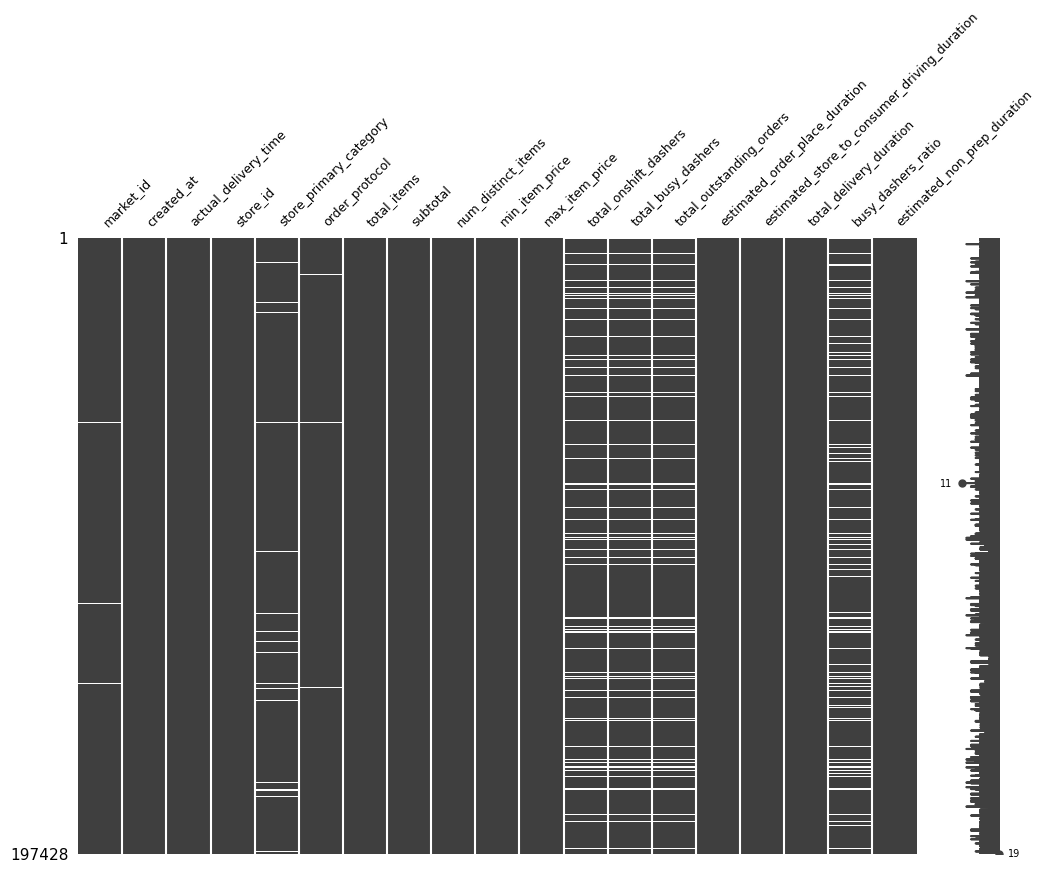

In [10]:
msno.matrix(df,figsize=(12, 8),fontsize=9,color=(0.25, 0.25, 0.25));

In [11]:
print(f"%{(len(df[df.isna().any(axis=1)]) / len(df)) * 100}")

%12.76009481937719


* The percantage of rows with null data is about %13 and about %9 of this comes from 3 different features. So let's remove all null data from dataset.

In [12]:
df = df.dropna()
df = df.reset_index(drop=True)
df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
total_delivery_duration                         0
busy_dashers_ratio                              0
estimated_non_prep_duration                     0
dtype: int64

* Let's check the unique values of categorical features(market_id, store_id, order_protocol)

In [13]:
print(f"""unique market_id: {df["market_id"].nunique()}
unique store_id: {df["store_id"].nunique()}
unique order_protocol: {df["order_protocol"].nunique()}""")

unique market_id: 6
unique store_id: 5477
unique order_protocol: 7


* `market_id` and `order_protocol` can be encoded due to the amount of unique values, but it would be inconvenient to encode `store_id` directly because after the encoding process, the feature will be created as much as the unique value of the feature, which may create an overfitting problem as well as reducing the model training performance.
<a href="https://www.datacamp.com/tutorial/one-hot-encoding-python-tutorial?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157098104375&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=684592139906&utm_targetid=aud-1645446892440:dsa-2264919291989&utm_loc_interest_ms=&utm_loc_physical_ms=1011347&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-oct24&gad_source=1&gclid=Cj0KCQjwvpy5BhDTARIsAHSilylgixtgL4ThNm06eqr-9Z7WkTMPWYCEY8kLMEr350DHQyq7Z2r5tf4aArqnEALw_wcB" target="_blank">[1]</a>
<a href="https://www.deepchecks.com/glossary/one-hot-encoding/#:~:text=Because%20this%20procedure%20generates%20several,variables%2C%20lowering%20the%20model's%20accuracy." target="_blank">[2]</a>
Therefore, we will code the `store_primary_category` feature instead of `market_id`.

In [14]:
# code the desired categorical features
market_id_dummies = create_dummies(df, 'market_id')
order_protocol_dummies = create_dummies(df, 'order_protocol')
store_primary_category_dummies = create_dummies(df, 'store_primary_category')

* Now, let's delete unnecessary columns from the dataframe then concat all dataframes.

In [15]:
df = df.drop(columns= ['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time','order_protocol'])
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,0.750000,735.0
3,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,1.200000,1241.0
4,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0,1.000000,651.0


In [16]:
train_df = pd.concat([df, market_id_dummies, order_protocol_dummies, store_primary_category_dummies], axis=1)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0,0,0,0,0,0,0,0,0,0
2,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,...,0,0,0,0,0,0,0,0,0,0
4,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,...,0,0,0,0,0,0,0,0,0,0


* Convert the data type of features to float (32) for machine learning models and for analyses

In [17]:
train_df = train_df.astype('float32')

* Let's check the descriptive statistics

In [18]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,...,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000,172236.000000
mean,3.202043,2700.330566,2.672925,686.035095,1162.204346,45.842148,42.721127,59.424900,307.356567,546.077942,...,0.000209,0.000116,0.005963,0.011159,0.000708,0.035875,0.001272,0.001324,0.004384,0.031706
std,2.676019,1828.425537,1.622634,520.029297,560.643982,34.286110,31.927736,52.600918,89.603142,218.565918,...,0.014456,0.010775,0.076988,0.105046,0.026605,0.185979,0.035636,0.036360,0.066063,0.175218
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1419.000000,1.000000,299.000000,799.000000,18.000000,16.000000,18.000000,251.000000,384.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2227.000000,2.000000,595.000000,1095.000000,38.000000,36.000000,42.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3420.000000,3.000000,945.000000,1396.000000,66.000000,63.000000,86.000000,446.000000,703.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Collinearity and Removing Redundancies<a id='4'></a>

* Let's check correlation heatmap of dataset

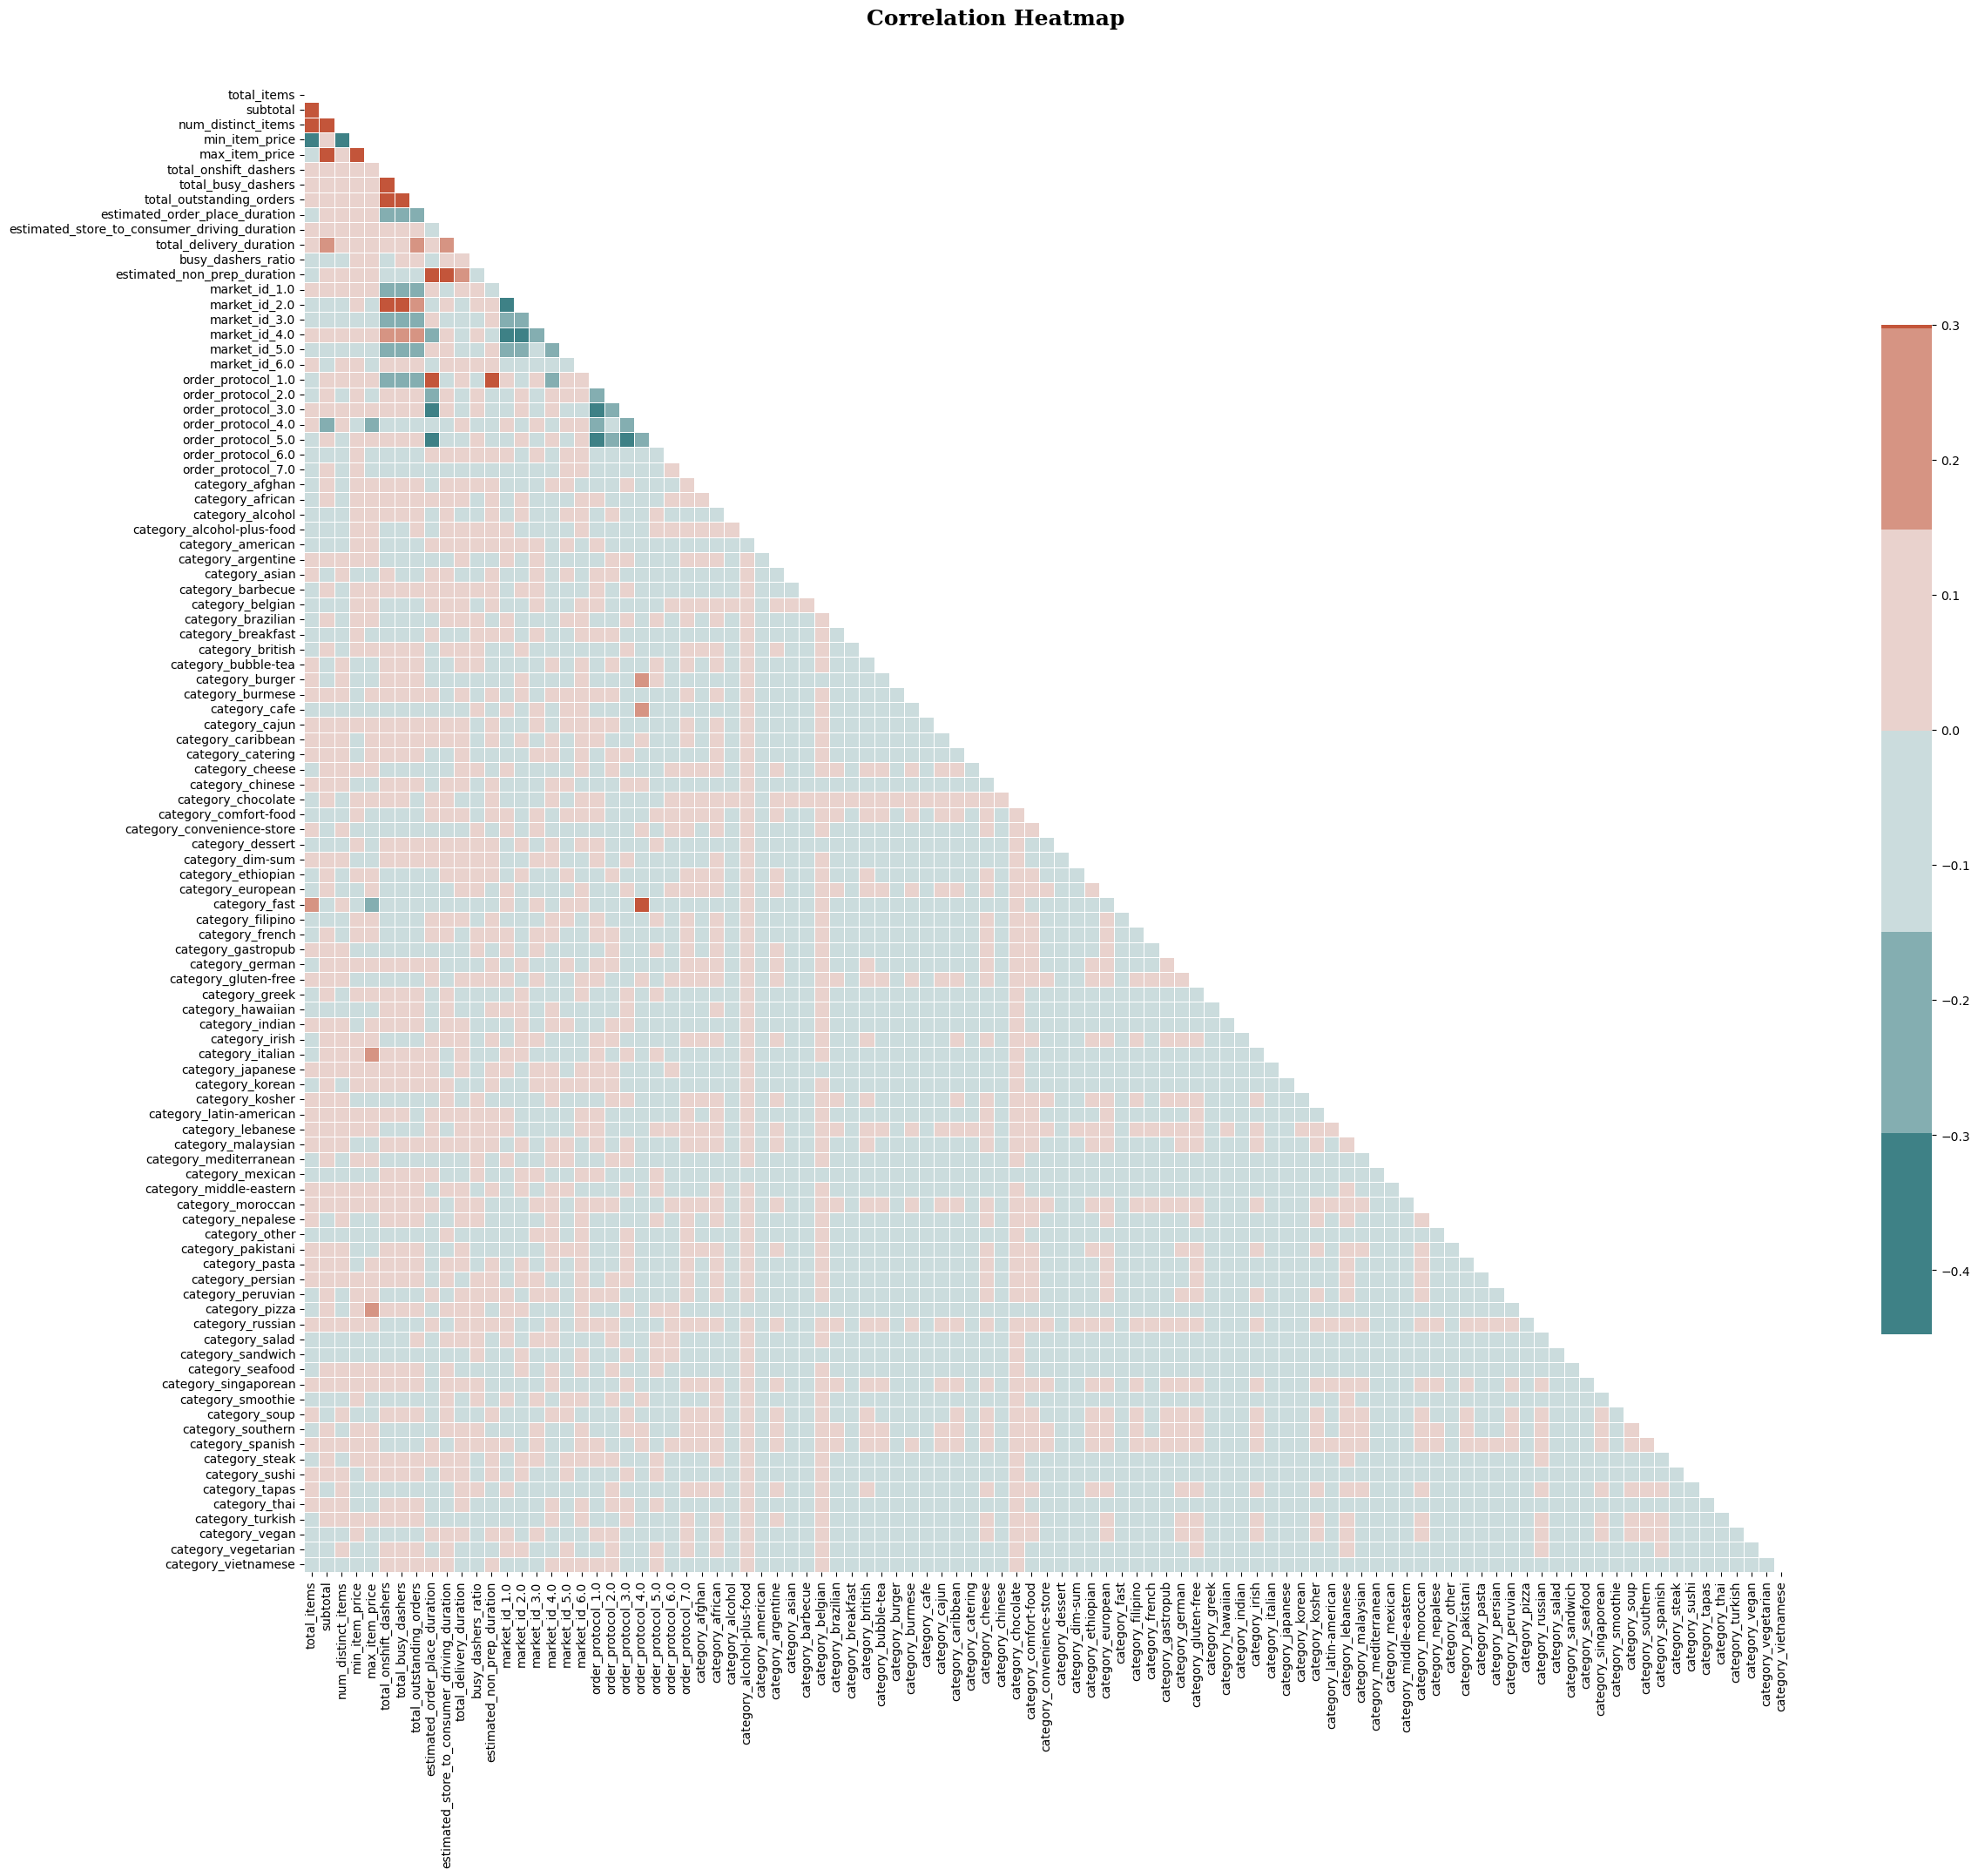

In [19]:
corr = train_df.corr()
correlation_heatmap(corr)

* Let's checkh the highest correlated features

In [20]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941705
                                              total_outstanding_orders       0.934585
total_busy_dashers                            total_outstanding_orders       0.931193
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.924029
estimated_order_place_duration                order_protocol_1.0             0.901261
total_items                                   num_distinct_items             0.756611
subtotal                                      num_distinct_items             0.682417
total_items                                   subtotal                       0.554731
min_item_price                                max_item_price                 0.540044
subtotal                                      max_item_price                 0.509098
order_protocol_4.0                            category_fast                  0.500220
num_distinct_items          

* There are strong correlations in the features `total_onshift_dashers`, `total_busy_dashers`, and `estimated_non_prep_duration`. There is also correlation between the dummies `order_protocol` and `market_id`. Therefore, drop the dummies in the dataset.

In [21]:
df = df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'estimated_non_prep_duration'])
train_df = pd.concat([df, store_primary_category_dummies], axis=1)
train_df = train_df.astype('float32')
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4771.0,3.0,820.0,1604.0,18.0,446.0,289.0,1586.0,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1525.0,1.0,1525.0,1525.0,8.0,446.0,795.0,2273.0,1.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,3620.0,2.0,1425.0,2195.0,7.0,446.0,205.0,2988.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.756611
subtotal                                      num_distinct_items                0.682417
total_items                                   subtotal                          0.554731
min_item_price                                max_item_price                    0.540044
subtotal                                      max_item_price                    0.509098
num_distinct_items                            min_item_price                    0.447435
total_items                                   min_item_price                    0.389421
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.187528
total_outstanding_orders                      estimated_order_place_duration    0.173278
subtotal                                      total_delivery_duration           0.171520
total_items                                   category_fast                     0.16

* There are still correlations between `num_distinct_items`, `subtotal` and `total_items`. Let's create new features related to these features and then delete the highly correlated features from the dataset.

In [23]:
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items'] / train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.859980
max_item_price                                avg_price_per_item                0.769751
min_item_price                                max_item_price                    0.540044
total_items                                   percent_distinct_item_of_total    0.444545
                                              min_item_price                    0.389421
                                              avg_price_per_item                0.310489
percent_distinct_item_of_total                avg_price_per_item                0.226331
category_pizza                                avg_price_per_item                0.218226
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.187528
max_item_price                                percent_distinct_item_of_total    0.178151
min_item_price                                percent_distinct_item_of_total    0.17

* Now there are issues with `min_item_price` and `max_item_price`. Let's create a new feature by subtracting the minimum item price and the maximum item price.

In [24]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['min_item_price', 'max_item_price'], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, n=20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.444545
                                              price_range_of_items              0.332925
                                              avg_price_per_item                0.310489
percent_distinct_item_of_total                avg_price_per_item                0.226331
category_pizza                                avg_price_per_item                0.218226
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.187528
total_outstanding_orders                      estimated_order_place_duration    0.173278
category_fast                                 avg_price_per_item                0.170744
total_items                                   category_fast                     0.166212
total_outstanding_orders                      total_delivery_duration           0.157878
category_italian                              avg_price_per_item                0.15

In [25]:
train_df.shape

(172236, 82)

* We finally solved the correlation issue. Let's check Multicollinearity in the next step.

## Multicollinearity and Feature Selection<a id='5'></a>